In [1]:
import pickle
import time
from rich.progress import track
import numpy as np
import math
from scipy.special import binom, perm
from itertools import combinations, permutations, product
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import random

from olympus.surfaces import CatCamel, CatMichalewicz, CatSlope, CatDejong # cat
from olympus.surfaces import Branin, Michalewicz, Levy, Dejong, Everest, Kilimanjaro, K2 # cont



In [38]:
#----------
# PLOTTING
#----------

def plot_contour(ax, X0, X1, y, xlims, ylims, vlims=[None, None], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_color='k', contour_alpha=1, cbar=False, cmap='RdBu'):
    # background surface
    if contour_lines is True:
        contours = ax.contour(X0, X1, y, n_contour_lines, colors=contour_color, alpha=contour_alpha, linestyles='dashed')
        if contour_labels is True:
            _ = ax.clabel(contours, inline=True, fontsize=labels_fs, fmt=labels_fmt)
    mappable = ax.imshow(y, extent=[xlims[0],xlims[1],ylims[0],ylims[1]], 
                         origin='lower', cmap=cmap, alpha=alpha, vmin=vlims[0], vmax=vlims[1])
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.5)
        
    return mappable

def plot_surface(surface, ax=None, N=100):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    x0 = np.linspace(0,1,N)
    x1 = np.linspace(0,1,N)
    X0, X1 = np.meshgrid(x0,x1)
    X = np.array([X0.flatten(), X1.flatten()]).T
    y = np.array(surface.run(X)).flatten()
    Y = np.reshape(y, newshape=np.shape(X0))

    _ = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=1, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_alpha=0.8, cbar=False, cmap='RdBu') #'golem'
    for param in surface.minima:
        x_min = param['params']
        ax.scatter(x_min[0], x_min[1], s=200, marker='*', color='#ffc6ff', zorder=20)
    
    
    
def plot_surface_cat(surface, ax=None, mark_min=False):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
        
    domain = np.arange(21)
    Z = np.zeros((21, 21))
    X = []
    for x_index, x in enumerate(domain):
        for y_index, y in enumerate(domain):
            x = ['x{}'.format(x_index), 'x{}'.format(y_index)]
            X.append(x)
            loss_value = surface.run(x)[0][0]
            Z[y_index, x_index] = loss_value
            
    # scale Camel for visualization 
    if type(surface).__name__ == 'CatCamelConstr':
        Z = np.log(Z)

    ax.imshow(Z, origin='lower', cmap = plt.get_cmap('RdBu'))
    if mark_min is True:
        min_params = surface.minima[0]['params']
        X_best = [int(min_params[0][1:]), int(min_params[1][1:])]
        _ = ax.scatter(X_best[0], X_best[1], marker='*', s=200, color='#ffc6ff', linewidth=2, zorder=20)
        
        
def plot_constr_surface_with_scatter(ax, surface, data, repeat=0):

    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    plot_constr_surface(surface, ax=ax, N=100)

    repeat = 0
    X = data[repeat].loc[:, ['x0', 'x1']]
    mask = surface.eval_constr(X.to_numpy())
    X_feas = X[mask]
    X_infs = X[~mask]

    ax.scatter(X_feas['x0'], X_feas['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
    ax.scatter(X_infs['x0'], X_infs['x1'], marker='X', s=100, color='white', edgecolor='k', zorder=10)
    
    
def plot_binary_scatter(surface, pkl_file, ax, n=0):
    with open(pkl_file, 'rb') as content:
        data = pickle.load(content)
    X = data[n].loc[:, ['x0', 'x1']]
    mask = surface.eval_constr(X.to_numpy())
    X_feas = X[mask]
    X_infs = X[~mask]
    
    ax.scatter(X_feas['x0'], X_feas['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
    ax.scatter(X_infs['x0'], X_infs['x1'], marker='X', s=100, color='white', edgecolor='k', zorder=10)
    

    
def plot_binary_scatter_cat(surface, pkl_file, ax, n=0):
    with open(pkl_file, 'rb') as content:
        data = pickle.load(content)
    X = data[n].loc[:, ['x0', 'x1']]
    mask = surface.eval_constr(X.to_numpy())
    X_feas_ = X[mask].values
    X_infs_ = X[~mask].values
    
    X_feas = []
    for x_ in X_feas_:
        x = [int(x_[0][2:]), int(x_[1][2:])]
        X_feas.append(x)
    
    X_infs = []
    for x_ in X_infs_:
        x = [int(x_[0][2:]), int(x_[1][2:])]
        X_infs.append(x)

    X_infs = np.array(X_infs)
    X_feas = np.array(X_feas)
    
    ax.scatter(X_feas[:,0], X_feas[:,1], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
    ax.scatter(X_infs[:,0], X_infs[:,1], marker='X', s=100, color='white', edgecolor='k', zorder=10)
    
    
def plot_hypervolume_trace(
    data, ax=None, color=None, label=None, categorical=False, stde=False, unc=True, maximize=True,
    linewidth=4, 
):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
    
    traces_max = []
    for d in data:
        traces_max.append(d['relative_hypervolumes'].cummax().values)
    traces_max = np.array(traces_max)
    
    mean = np.nanmean(traces_max, axis=0)
    if stde is True:
        # standard error
        stde = np.nanstd(traces_max, axis=0, ddof=1) / np.sqrt(np.shape(traces_max)[0] - 1)
    else:
        # standard deviation
        stde = np.nanstd(traces_max, axis=0, ddof=1)
        
    x = range(1, np.shape(traces_max)[1]+1, 1)

    ax.plot(x, mean, color='#444444', linewidth=linewidth+1)
    plot_ = ax.plot(x, mean, color=color, linewidth=linewidth, label=label)
    
    if unc is True:
        ax.fill_between(x, y1=mean - 1.96*stde, y2=mean + 1.96*stde, alpha=0.2, color=color)
        ax.plot(x, mean - 1.96*stde, color=color, linewidth=1, alpha=0.5)
        ax.plot(x, mean + 1.96*stde, color=color, linewidth=1, alpha=0.5)
        
    return plot_


# make hypervolume plot

def plot_hypervolume_area(
    objs, 
    reference_point, 
    theo_best_objs=None,
    label=None, 
    ax=None, 
    color_ix=0, 
    scatter_points=False,
):
    
    COLORS = [
        '#afcbff', 
        '#aec695',
        '#ffa899',
    ]
    
    x = objs[:,0] # Ng values
    y = objs[:,1] # f_x values

    # Zip x and y into a numpy ndarray
    coordinates = np.array(sorted(zip(x, y)))
    # Empty pareto set
    pareto_set = np.full(coordinates.shape, np.inf)
    
    i = 0
    for point in coordinates:
        if i == 0:
            pareto_set[i] = point
            i += 1
        elif point[1] < pareto_set[:, 1].min():
            pareto_set[i] = point
            i += 1

    # Get rid of unused spaces
    pareto_set = pareto_set[:i + 1, :]
    
    # get intersection points of reference point and x, y values
    trunc_pareto_set = pareto_set[:-1]
    intersect_1 = np.array([np.amin(trunc_pareto_set[:,0]), reference_point[1]])
    intersect_2 = np.array([reference_point[0], np.amin(trunc_pareto_set[:,1])])

    # Add reference point to the pareto set
    pareto_set[i] = reference_point  # pareto set is sorted by increasing x-values
      
    # add in intersection points
    pareto_set = np.concatenate([
        intersect_1.reshape((1, intersect_1.shape[0])), 
        pareto_set[:-1, :],
        intersect_2.reshape((1, intersect_2.shape[0])), 
        pareto_set[-1, :].reshape((1, pareto_set.shape[1])),
    ] )
     
    # These points will define the path to be plotted and filled
    x_path_of_points = []
    y_path_of_points = []

    for index, point in enumerate(pareto_set):
        if index < len(pareto_set) - 1:
            
            next_point = pareto_set[index + 1]
            
            if index in [0, len(pareto_set)-2]:
                # these are the intersection points, plot invisible point
                ax.plot(
                    [point[0], point[0]], 
                    [point[1], next_point[1]],
                    marker='o', markersize=0,
                    c=COLORS[color_ix],
                )
                ax.plot(
                    [point[0], next_point[0]],
                    [next_point[1], next_point[1]],
                    marker='o', markersize=0,
                    c=COLORS[color_ix],
                )
            else:
                # plot horizontal line segment (x current, y current) --> (x next, y current)
                # invisible point
                ax.plot(
                    point[0],
                    point[1],
                    marker='o', markersize=4, 
                    mfc='black', mec='black', # visible start point
                )
                ax.plot(
                    [point[0], next_point[0]], # x coords of current point
                    [point[1], point[1]], # y coords of current point and next
                    c=COLORS[color_ix], # line segment
                )
                # plot vertical line segment (x next, y current) --> (x next, y next)
                # visible point
                ax.plot(
                    [next_point[0], next_point[0]], 
                    [point[1], next_point[1]],
                    c=COLORS[color_ix], # line segment
                )
                if index == len(pareto_set)-3:
                    # plot the ending point as invisible
                    ax.plot(
                        next_point[0],
                        next_point[1],
                        marker='o', markersize=0,  # invisible ending point
                    )
                else:
                    ax.plot(
                        next_point[0],
                        next_point[1],
                        marker='o', markersize=4, 
                        mfc='black', mec='black', # visible ending point
                    )

            x_path_of_points += [point[0], next_point[0], next_point[0]]
            y_path_of_points += [point[1], point[1], next_point[1]]
            
    

    # Link 1 to Reference Point
    ax.plot([
        pareto_set[0][0], reference_point[0]], 
        [pareto_set[0][1], reference_point[1]], 
        c=COLORS[color_ix]
    )
    # Link 2 to Reference Point
    ax.plot(
        [pareto_set[-1][0], reference_point[0]], 
        [pareto_set[-2][1], reference_point[1]], 
        c=COLORS[color_ix]
    )
    # Highlight the Reference Point
    ax.plot(reference_point[0], reference_point[1], 'o', color='red', markersize=8)

    # scatter on all non-pareto points if requested
    if scatter_points:
        bools = ~np.isin(coordinates, pareto_set) #.reshape(-1, coordinates.shape[1])
        non_pareto = np.array([c for ix, c in enumerate(coordinates) if any(bools[ix])])
        
        if not non_pareto.shape[0]==0:
            ax.plot(
                non_pareto[:,0], 
                non_pareto[:,1], 
                marker='o',
                markersize=4,
                ls='',
                color=COLORS[color_ix],
            )
    
    # Fill the area between the Pareto set and Ref y
    ax.fill_betweenx(y_path_of_points, x_path_of_points, max(x_path_of_points) * np.ones(len(x_path_of_points)),
                      color=COLORS[color_ix], alpha=0.2, label=label)
    
    # scatter on theoretical best values, if provided
    if theo_best_objs is not None:
        ax.plot(
            theo_best_objs[:,0],
            theo_best_objs[:,1],
            marker='*',
            markersize=5,
            ls='',
            color='k',
        )
    
    
    

In [40]:
total_options(4, 441)

37822859361

In [39]:
#------------------
# HELPER FUNCTIONS
#------------------
def stirling_sum(Ns):
    """ ...
    """
    stirling = lambda n,k: int(1./math.factorial(k) * np.sum([(-1.)**i * binom(k,i)*(k-i)**n for i in range(k)]))
    return np.sum([stirling(Ns, k) for k in range(Ns+1)])


def total_options(Ns, cart_prod_card):
    """ ... 
    """
    stirling = lambda n,k: int(1./math.factorial(k) * np.sum([(-1.)**i * binom(k,i)*(k-i)**n for i in range(k)]))
    return int( np.sum([stirling(Ns, k)*perm(cart_prod_card,k) for k in range(Ns+1)]) )
    
    

def partition(S):
    """ ...
    """
    if len(S) == 1:
        yield [S]
        return 

    first = S[0]
    for smaller in partition(S[1:]):
        for n, subset in enumerate(smaller):
            yield smaller[:n]+[[first] + subset]+smaller[n+1:]
        yield [[first]]+smaller 
    
def gen_partitions(S):
    """
    generate all possible partitions of Ns-element set S
    
    Args: 
        S (list): list of non-functional parameters S
    """
    return [p for _, p in enumerate(partition(S),1)]


def gen_permutations(X_funcs, Ng):
    """ generate all possible functional parameter permutations
    given number of non-functional parameter subsets Ng
    
    Args: 
        X_funcs (np.ndarray): numpy array with all functional 
            possile functional parameters
        Ng (int): number of non-functional parameter subsets
        
    Returns
        (np.ndarray): array of parameter permutations of
            shape (# perms, Ng, # params)
    """
    
    return np.array(list(permutations(X_funcs, Ng)))

def measure_objective(xgs, G, surf_map, is_categorical):
    """ ... 
    """
    f_x = 0.
    for g_ix, Sg in enumerate(G):
        for si in Sg:
            f_x += measure_single_obj(xgs[g_ix], si, surf_map, is_categorical)
    return f_x


def measure_single_obj(X_func, si, surf_map, is_categorical):
    if is_categorical:
        X_func = list([str(elem) for elem in X_func])
    return surf_map[si].run(X_func)[0][0]


def estimate_optima(S, surf_map, num_samples=int(1e4), is_categorical=False):
    """ Estimates optimum for each of the possible Ngs
    """
    poss_Ngs = np.arange(len(S))+1
    fxs = {poss_Ng: [] for poss_Ng in poss_Ngs}
    num_Ngs = {poss_Ng:0 for poss_Ng in poss_Ngs}
    
    print(fxs)
    
    start_time = time.time()
    
    # generate all the partitions of non-functional parameters
    Gs = gen_partitions(S)
    print('total non-functional partitions : ', len(Gs))
    # histogram of Ngs
    for G in Gs:
        num_Ngs[len(G)] += 1
    
    for G_ix, G in track(enumerate(Gs), total=len(Gs), description='Evaluating candidates'):
        Ng = len(G)
        # so we eval same num total points on each Ng
        num_samples_eff = int(num_samples/num_Ngs[Ng]) 
        print(f'G : {G}\t num_samples_eff : {num_samples_eff}\t num_samples : {num_samples}')
         
        if is_categorical:
            # categorical surfaces
            opts = [f'x{i}' for i in range(21)]
            X_funcs = np.random.choice(opts, replace=True, size=(num_samples_eff, Ng, 2))            
        else:
            # continuous surface
            # generate samples
            X_funcs =  np.random.uniform(size=(num_samples_eff, Ng, 2)) # 2d functions only
        
        for X_func in X_funcs:
            f_x = measure_objective(X_func, G, surf_map, is_categorical=is_categorical)
            fxs[Ng].append({'G': G, 'X_func': X_func,'f_x': f_x,})

    
            
    total_time = round(time.time()-start_time,2)
    print(f'[INFO] Done in {total_time} s')
    
    # get the best (min) values
    best_vals = {}
    for Ng in poss_Ngs:
        
        fxs_Ng = fxs[Ng]
        fx_vals_Ng = [d['f_x'] for d in fxs_Ng]
        best_idx = np.argmin(fx_vals_Ng)
        best_dict = fxs_Ng[best_idx]
        best_vals[Ng] = best_dict
        
    
    
    return best_vals, fxs

#---------------------------
# BUCHWALD DATASET SPECIFIC
#---------------------------

def buchwald_lookup(params, target, lookup):
    """ lookup the yield for a given functional/non-functional
    parameter setting
    """
    base = params[0]
    ligand = params[1]
    additive = params[2]
    sub_df = lookup[
        (lookup['base_ix']==base) &
        (lookup['ligand_ix']==ligand) &
        (lookup['additive_ix']==additive) &
        (lookup['aryl_halide_ix']==target)
    ]
    if sub_df.shape[0] == 1:
        yield_ = sub_df.loc[:, 'yield'].to_numpy()[0]
    elif sub_df.shape[0] < 1:
        yield_ = 0.0
    
    return yield_

def measure_objective_buchwald(xgs, G, lookup):
    """
    Args:
        x_gs (np.ndarray): array of proposed general parameters (Ng x 1)
        G (dict): keys are indices of non-functional subsets Sg, values are lists
            of non-functional parameter names assigned to that subset
    """
    f_x = 0.
    for g_ix, Sg in enumerate(G):
        for si in Sg:
            f_x += buchwald_lookup(xgs[g_ix], si, lookup)
        
    return f_x



def estimate_optima_buchwald(S, lookup, num_samples=int(1e4)):
    """ Estimates optimum for each of the possible Ngs
    """
    poss_Ngs = np.arange(len(S))+1
    fxs = {poss_Ng: [] for poss_Ng in poss_Ngs}
    num_Ngs = {poss_Ng:0 for poss_Ng in poss_Ngs}
    
    #print(fxs)
    
    start_time = time.time()
    
    # generate all the partitions of non-functional parameters
    Gs = gen_partitions(S)
    print('total non-functional partitions : ', len(Gs))
    # histogram of Ngs
    for G in Gs:
        num_Ngs[len(G)] += 1
    
    #print(num_Ngs)
    
    for G_ix, G in track(enumerate(Gs), total=len(Gs), description='Evaluating candidates'):
        Ng = len(G)
        # so we eval same num total points on each Ng
        num_samples_eff = int(num_samples/num_Ngs[Ng]) 
        #print(f'G : {G}\t num_samples_eff : {num_samples_eff}\t num_samples : {num_samples}')
         
        base_opts = np.arange(3)
        ligand_opts = np.arange(4)
        additive_opts = np.arange(23)
        base_select_opts = np.random.choice(base_opts, replace=True, size=(num_samples_eff*Ng,))
        ligand_select_opts = np.random.choice(ligand_opts, replace=True, size=(num_samples_eff*Ng,))
        additive_select_opts = np.random.choice(additive_opts, replace=True, size=(num_samples_eff*Ng,))
        X_funcs = np.stack((base_select_opts, ligand_select_opts, additive_select_opts), axis=0)
        X_funcs = X_funcs.reshape((num_samples_eff, Ng, 3))
        
        for X_func in X_funcs:
            f_x = measure_objective_buchwald(X_func, G, lookup)
            fxs[Ng].append({'G': G, 'X_func': X_func,'f_x': f_x,})

    
            
    total_time = round(time.time()-start_time,2)
    print(f'[INFO] Done in {total_time} s')
    
    # get the best (min) values
    best_vals = {}
    for Ng in poss_Ngs:
        
        fxs_Ng = fxs[Ng]
        fx_vals_Ng = [d['f_x'] for d in fxs_Ng]
        best_idx = np.argmax(fx_vals_Ng) # maximizing yield in this case
        best_dict = fxs_Ng[best_idx]
        best_vals[Ng] = best_dict
        
    return best_vals, fxs


In [4]:
#------------
# CONTINUOUS
#------------

surf_map_cont = {
    0: Branin(),
    1: Dejong(),
    2: Michalewicz(),
    3: Levy(),
#     #4: Everest(), 
#     #5: Kilimanjaro(),
#     #6: K2()
}


#-------------
# CATEGORICAL
#-------------

surf_map_cat = {
    0: CatCamel(param_dim=2, num_opts=21),
    1: CatDejong(param_dim=2, num_opts=21),
    2: CatMichalewicz(param_dim=2, num_opts=21),
    3: CatSlope(param_dim=2, num_opts=21),
}

S = [i for i in range(len(surf_map_cat))]
poss_Ngs = np.arange(len(S))+1

In [5]:
# get the minimum of the each cat surface 
mins_ = []
for ix, surf in surf_map_cat.items():
    print(surf.minima)
    mins_.append(surf.minima[0]['value'])
abs_min_ = np.sum(mins_) # theoretical best value

print('theoretical best cat : ', abs_min_)

[{'params': ['x7', 'x11'], 'value': 12.177205282080257}]
[{'params': ['x10', 'x10'], 'value': 0.0}]
[{'params': ['x14', 'x10'], 'value': -1.8010702893119994}]
[{'params': ['x0', 'x0'], 'value': 0.0}]
theoretical best cat :  10.376134992768257


In [75]:
# get the minimum of the each cont surface 
mins_ = []
for ix, surf in surf_map_cont.items():
    print(surf.minima)
    mins_.append(surf.minima[0]['value'])
abs_min_ = np.sum(mins_) # theoretical best value

print('theoretical best cat : ', abs_min_)

[{'params': array([0.12389382, 0.81833333]), 'value': 0.39788735772973816}, {'params': array([0.54277284, 0.15166667]), 'value': 0.39788735772973816}, {'params': array([0.961652, 0.165   ]), 'value': 0.39788735775266204}]
[{'params': [0.5, 0.5], 'value': 0.0}]
[{'params': array([0.70120676, 0.4999999 ]), 'value': -1.8013034100904854}]
[{'params': [0.55, 0.55], 'value': 1.4997597826618576e-32}]
theoretical best cat :  -1.4034160523607473


In [ ]:
# get the minimum of the each cat surface 
# maxs_ = []
# for ix, surf in surf_map.items():
#     print(surf.kind)
#     try:
#         print(surf.maxima)
#         maxs_.append(surf.maxima[0]['value'])
#     except:
#         pass
# abs_max_ = np.sum(maxs_) # theoretical best value

# print('theoretical worst : ', abs_max_)

In [8]:
indiv_optima_cat = [
    {'params': ['x7', 'x11'], 'value': 12.177205282080257},
    {'params': ['x10', 'x10'], 'value': 0.0},
    {'params': ['x14', 'x10'], 'value': -1.8010702893119994},
    {'params': ['x0', 'x0'], 'value': 0.0}
]

indiv_optimia_cont =[
    {'params': np.array([0.12389382, 0.81833333]), 'value': 0.39788735772973816}, #{'params': np.array([0.54277284, 0.15166667]), 'value': 0.39788735772973816}, {'params': array([0.961652, 0.165   ]), 'value': 0.39788735775266204}]
    {'params': np.array([0.5, 0.5]), 'value': 0.0},
    {'params': np.array([0.70120676, 0.4999999 ]), 'value': -1.8013034100904854},
    {'params': np.array([0.55, 0.55]), 'value': 1.4997597826618576e-32},
]

def estimate_optima_cat(surf_map, indiv_optima_cat, is_cont=False, N=100):
    
    S = [i for i in range(len(surf_map))]
    poss_Ngs = np.arange(len(S))+1
    fxs = {poss_Ng: None for poss_Ng in poss_Ngs}
    num_Ngs = {poss_Ng:0 for poss_Ng in poss_Ngs}
    
        
    if not is_cont:
        # make cartesian product space
        param_options = [[f'x{i}' for i in range(21)] for _ in range(2)] # 2 dims, 21 opts
        cart_product = list(product(*param_options))
        cart_product = [list(elem) for elem in cart_product] 
    
    else:
        x0 = np.linspace(0,1,N)
        x1 = np.linspace(0,1,N)
        X0, X1 = np.meshgrid(x0,x1)
        cart_product = np.array([X0.flatten(), X1.flatten()]).T
        

    for Ng in poss_Ngs:
        
        if Ng > 1 and Ng != max(poss_Ngs):
            num_opt = Ng-1
            
            surf_combs = list(combinations(S, r=num_opt))
        
            best_config = []
            for surf_comb_opt in surf_combs:
                fixed_surf_opts = [indiv_optima_cat[ix] for ix in surf_comb_opt]
                
                other_surfs = [surf_map[ix] for ix in range(len(surf_map)) if ix not in surf_comb_opt]
                other_best_params, other_best_val = full_search_one_param(other_surfs, cart_product)
                best_config.append({
                    'opt_surf_ix': surf_comb_opt,
                    'other_best_params': other_best_params,
                    'other_best_val': other_best_val,
                })
                
            all_other_best_vals = [d['other_best_val'] for d in best_config]
            best_ix = np.argmin(all_other_best_vals)
            best = best_config[best_ix]
            
            Gs_ = []
            X_funcs_ = []
            for opt_surf_ix in best['opt_surf_ix']:
                Gs_.append([opt_surf_ix])
                X_funcs_.append(indiv_optima_cat[opt_surf_ix]['params'])
                
            Gs_.append([ix for ix in S if ix not in best['opt_surf_ix']])
            X_funcs_.append(best['other_best_params'])
            
            f_x = np.sum([indiv_optima_cat[ix]['value'] for ix in best['opt_surf_ix']]+[best['other_best_val']])
            
            fxs[Ng] = {
                'G': Gs_,
                'X_func': X_funcs_ ,
                'f_x': f_x,
            }  
            
        elif Ng == max(poss_Ngs):
            # here we can just take the optimum of the individual surfaces themselves
            fxs[Ng] = {
                'G': [[ix] for ix in S],
                'X_func': [d['params'] for d in indiv_optima_cat],
                'f_x': np.sum([d['value'] for d in indiv_optima_cat]),
            }
            
        elif Ng == 1:
            # here we can just conduct a grid search with all the surfaces
            best_params, best_val = full_search_one_param([surf_map[ix] for ix in S], cart_product)
            fxs[Ng] = {
                'G': [S],
                'X_func': [best_params],
                'f_x': best_val,
            }
        
    
    return fxs


def full_search_one_param(surfs, all_params):
    vals = [
        np.sum([surf.run(param)[0][0] for surf in surfs]) for param in all_params
    ]
    best_ix = np.argmin(vals)
    best_params = all_params[best_ix]
    best_val = vals[best_ix]
    return best_params, best_val
    

In [9]:
best_vals_cont = estimate_optima_cat(surf_map_cont, indiv_optimia_cont, is_cont=True, N=200)

In [10]:
best_vals_cont

{1: {'G': [[0, 1, 2, 3]],
  'X_func': [array([0.52763819, 0.24623116])],
  'f_x': 6.798261122614861},
 2: {'G': [[0], [1, 2, 3]],
  'X_func': [array([0.12389382, 0.81833333]), array([0.54271357, 0.50251256])],
  'f_x': 0.33612529823817294},
 3: {'G': [[0], [1], [2, 3]],
  'X_func': [array([0.12389382, 0.81833333]),
   array([0.5, 0.5]),
   array([0.55276382, 0.50753769])],
  'f_x': -0.5063907050828513},
 4: {'G': [[0], [1], [2], [3]],
  'X_func': [array([0.12389382, 0.81833333]),
   array([0.5, 0.5]),
   array([0.70120676, 0.4999999 ]),
   array([0.55, 0.55])],
  'f_x': -1.4034160523607473}}

In [11]:
best_vals_cat = estimate_optima_cat(surf_map_cat, indiv_optima_cat)

In [12]:
best_vals_cat

{1: {'G': [[0, 1, 2, 3]],
  'X_func': [['x7', 'x11']],
  'f_x': 15.329781561557427},
 2: {'G': [[0], [1, 2, 3]],
  'X_func': [['x7', 'x11'], ['x10', 'x10']],
  'f_x': 12.12860967196121},
 3: {'G': [[0], [3], [1, 2]],
  'X_func': [['x7', 'x11'], ['x0', 'x0'], ['x10', 'x10']],
  'f_x': 11.176228719580257},
 4: {'G': [[0], [1], [2], [3]],
  'X_func': [['x7', 'x11'], ['x10', 'x10'], ['x14', 'x10'], ['x0', 'x0']],
  'f_x': 10.376134992768257}}

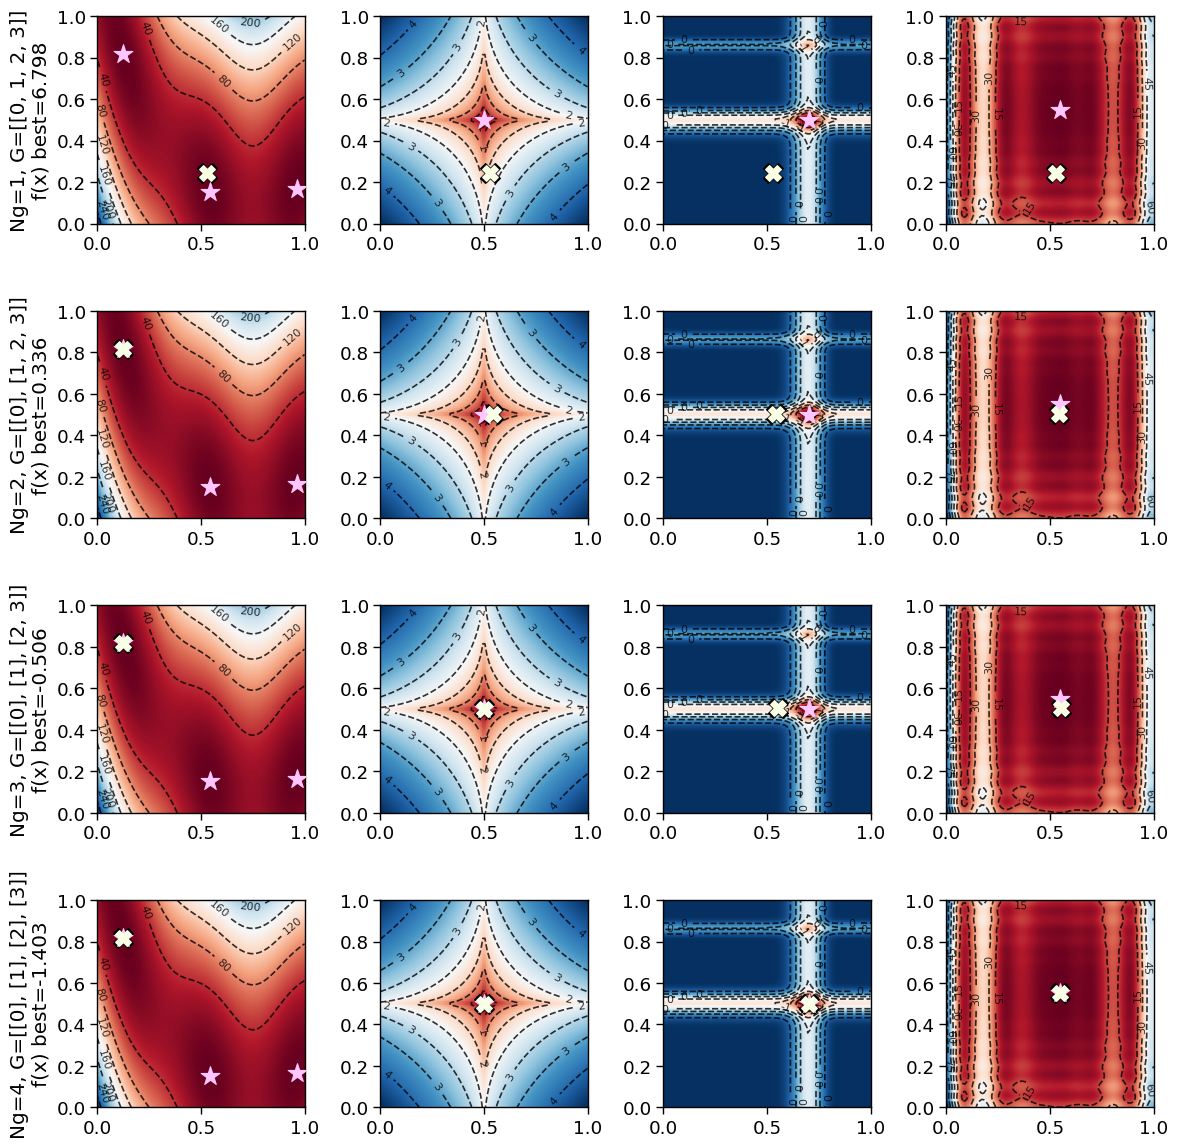

In [13]:
# plot continuous surfaces
fig, axes = plt.subplots(4,4,figsize=(12, 12))
poss_Ngs = np.arange(len(surf_map_cont))+1
for Ng in poss_Ngs:

    surf1 = Branin()
    plot_surface(surf1, ax=axes[Ng-1,0], N=100)
    surf2 = Dejong()
    plot_surface(surf2, ax=axes[Ng-1,1], N=100)
    surf3 = Michalewicz()
    plot_surface(surf3, ax=axes[Ng-1,2], N=100)
    surf4 = Levy()
    plot_surface(surf4, ax=axes[Ng-1,3], N=100)


for Ng in poss_Ngs:
    f_x_best = best_vals_cont[Ng]['f_x']
    G_best = best_vals_cont[Ng]['G']
    X_func_best = best_vals_cont[Ng]['X_func']
    for X, S in zip(X_func_best, G_best):
        for si in S:
            axes[Ng-1, si].scatter(
                X[0], X[1], 
                marker='X', s=125, 
                color='#f8ffe5', linewidth=1, 
                zorder=20,
            )
            axes[Ng-1,si].scatter(
                X[0], X[1], 
                marker='X', s=200, 
                color='k', linewidth=1, 
                zorder=19,
            )
            # add ylabel
            axes[Ng-1,0].set_ylabel(f'Ng={Ng}, G={G_best}\nf(x) best={round(f_x_best,3)}')

plt.tight_layout()

plt.savefig('cont_analytic_general_params.png', dpi=300)

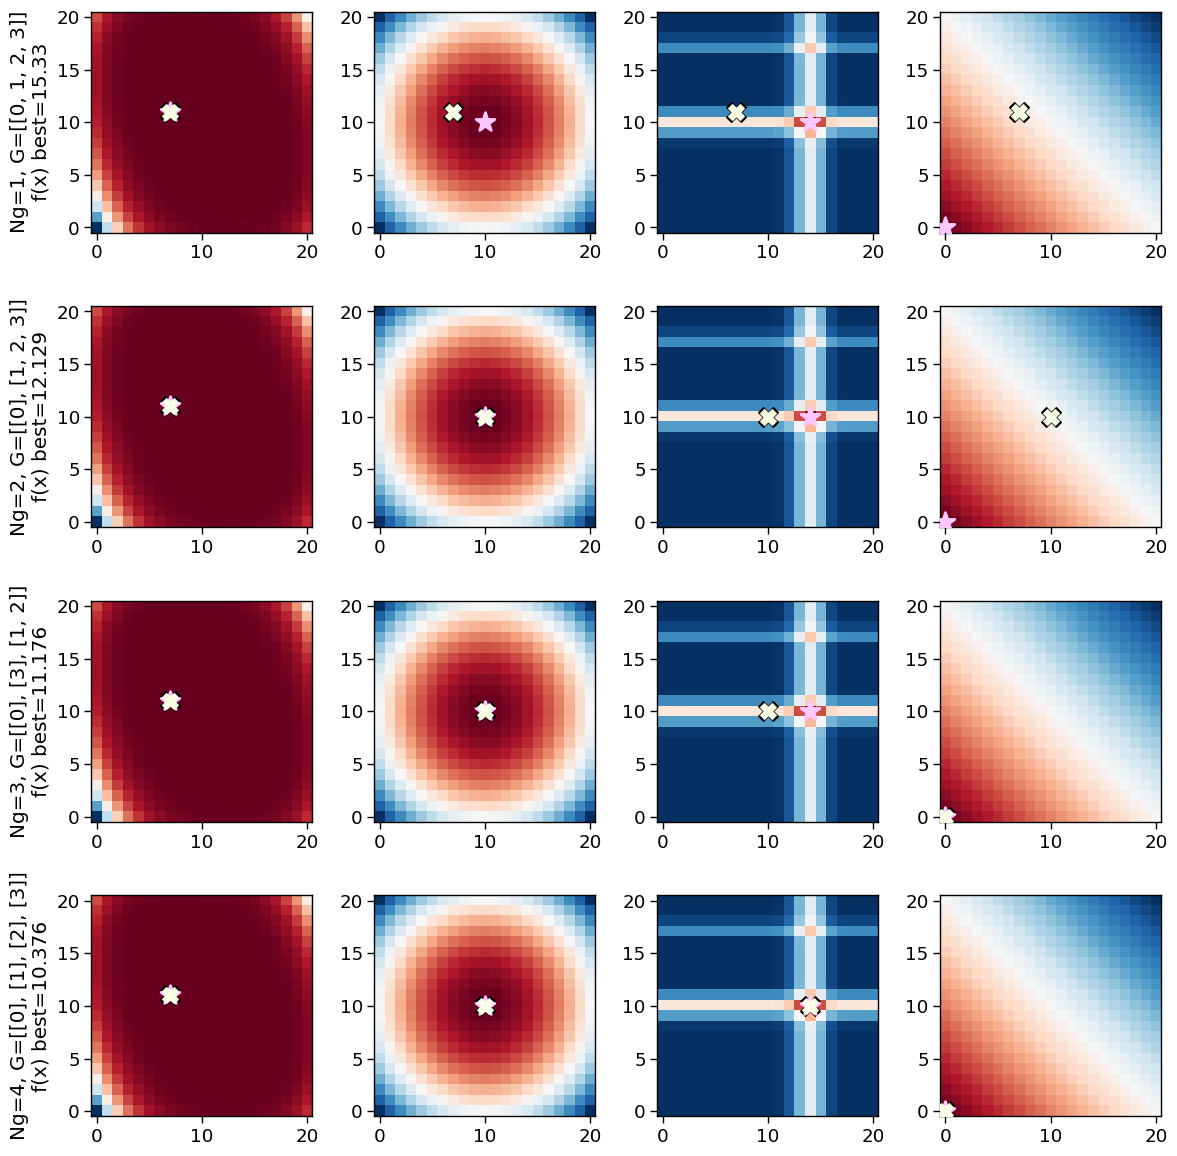

In [17]:
# plot categorical surfaces
fig, axes = plt.subplots(4,4,figsize=(12, 12))


poss_Ngs = np.arange(len(surf_map_cat))+1
for Ng in poss_Ngs:

    surf1 = CatCamel(param_dim=2, num_opts=21)
    plot_surface_cat(surf1, ax=axes[Ng-1,0], mark_min=True)
    surf2 = CatDejong(param_dim=2, num_opts=21)
    plot_surface_cat(surf2, ax=axes[Ng-1,1], mark_min=True)
    surf3 = CatMichalewicz(param_dim=2, num_opts=21)
    plot_surface_cat(surf3, ax=axes[Ng-1,2], mark_min=True)
    surf4 = CatSlope(param_dim=2, num_opts=21)
    plot_surface_cat(surf4, ax=axes[Ng-1,3], mark_min=True)


for Ng in poss_Ngs:
    f_x_best = best_vals_cat[Ng]['f_x']
    G_best = best_vals_cat[Ng]['G']
    X_func_best = best_vals_cat[Ng]['X_func']
    for X, S in zip(X_func_best, G_best):
        for si in S:
            axes[Ng-1, si].scatter(
                int(X[0][1:]), int(X[1][1:]), 
                marker='X', s=125, 
                color='#f8ffe5', linewidth=1, 
                zorder=20,
            )
            axes[Ng-1,si].scatter(
                int(X[0][1:]), int(X[1][1:]), 
                marker='X', s=200, 
                color='k', linewidth=1, 
                zorder=19,
            )
            # add ylabel
            axes[Ng-1,0].set_ylabel(f'Ng={Ng}, G={G_best}\nf(x) best={round(f_x_best,3)}')

plt.tight_layout()

plt.savefig('cat_analytic_general.png', dpi=300)

## Plot continuous analytical tests

num results rand :  30
num results al :  30


(0.8, 1.0)

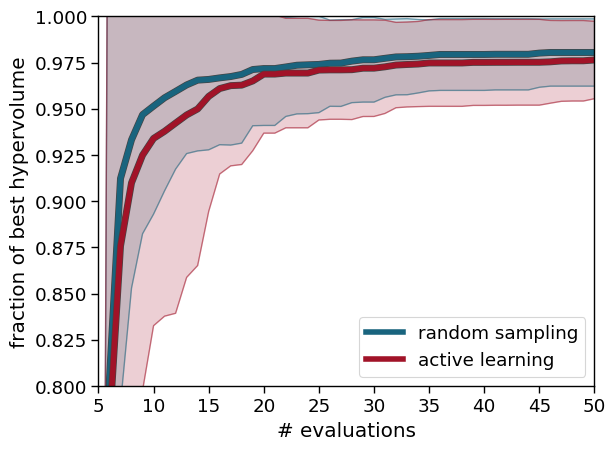

In [19]:

res_rand = pickle.load(open('../tests/cont_analytic/random/results.pkl', 'rb'))
res_al = pickle.load(open('../tests/cont_analytic/medusa/results.pkl', 'rb'))
print('num results rand : ', len(res_rand))
print('num results al : ', len(res_rand))
fig, ax = plt.subplots()
plot_hypervolume_trace(res_rand, ax=ax, color='#19647e', label='random sampling')
plot_hypervolume_trace(res_al, ax=ax, color='#a11328', label='active learning')

ax.set_ylabel('fraction of best hypervolume')
ax.set_xlabel('# evaluations')
ax.legend()

ax.set_xlim(5, 50)
ax.set_ylim(0.8, 1.0)

(-0.05, 1.05)

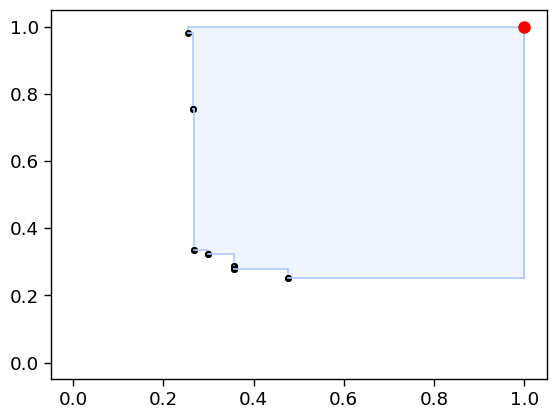

In [67]:
# testing plotting
np.random.seed(100712)
est_best_objs = np.random.uniform(0.25, 1., size=(100,2))

# w_ref for hypervolume computation
w_ref = np.array([1., 1.])

fig, ax = plt.subplots()
plot_hypervolume_area(est_best_objs, w_ref, ax=ax)


ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
#ax.set_yscale('log')

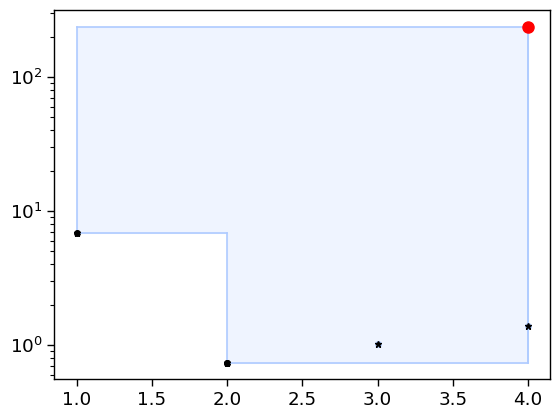

In [68]:
# theoretical maximum
# theo_max_val = 308.129+4.72+0.+150.

est_best_objs = np.array([
    [1., 6.800270000320467],
    [2., 0.7368735958997857],
    [3., 1.021902483359942],
    [4., 1.382150783615172]
])

best_objs = np.array([[1., 29.38129348],
       [2., 194.97737492],
       [3., 208.91016699],
       [4., 237.6472516]])

# w_ref for hypervolume computation
w_ref = np.array([4., np.max(best_objs[:, 1])])

fig, ax = plt.subplots()
plot_hypervolume_area(est_best_objs, w_ref, theo_best_objs=est_best_objs, ax=ax, scatter_points=True)

ax.set_yscale('log')

[[  1.         217.57462449]
 [  2.         324.14742828]
 [  3.         260.1694817 ]
 [  4.          92.76941766]]
[[ 1.         33.79507337]
 [ 2.         37.38468858]
 [ 3.         18.32741472]
 [ 4.         42.24288119]]


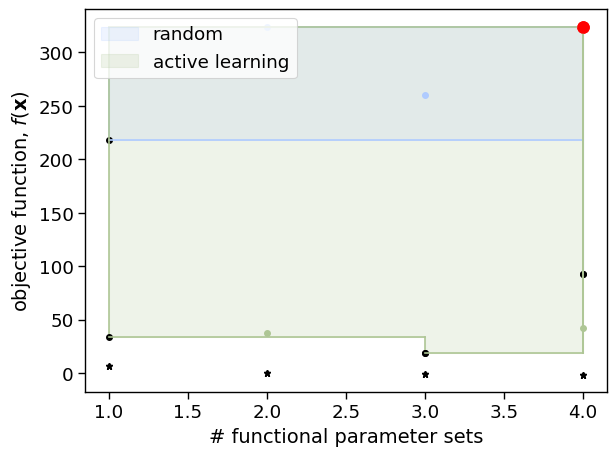

In [37]:
# print(res_rand[0]['all_meas_objs'][10])
objs_rand = res_rand[0]['all_meas_objs'][9][:, [1, 0]]
objs_al = res_rand[1]['all_meas_objs'][13][:, [1, 0]]

print(objs_rand)
print(objs_al)

est_best_objs_cont = np.array([
    [1., 6.798],
    [2., 0.336],
    [3., -0.506],
    [4., -1.403]
])


# w_ref for hypervolume computation
w_ref_cont = np.array([4., np.max(np.concatenate((objs_al[:, 1], objs_rand[:, 1])))])

fig, ax = plt.subplots()
plot_hypervolume_area(
    objs_rand, w_ref_cont, theo_best_objs=est_best_objs_cont, label='random', ax=ax, color_ix=0, scatter_points=True)
plot_hypervolume_area(
    objs_al, w_ref_cont, theo_best_objs=est_best_objs_cont, label='active learning', ax=ax, color_ix=1, scatter_points=True
)

ax.legend(loc='upper left')

ax.set_xlabel('# functional parameter sets',fontsize=14)
ax.set_ylabel(r'objective function, $f(\mathbf{x})$',fontsize=14)

#ax.set_yscale('log')
plt.tight_layout()
plt.savefig('cont_analytic_hypervol_both.png', dpi=300)

## Plot categorical analytic tests

In [ ]:
res_al = pickle.load(open('../tests/cat_analytic/medusa/results.pkl', 'rb'))
print('num results al : ', len(res_al))

fig, ax = plt.subplots()
plot_hypervolume_trace(res_al, ax=ax, color='#a11328', label='active learning')

ax.set_ylabel('fraction of best hypervolume')
ax.set_xlabel('# evaluations')
ax.legend()

ax.set_xlim(5, 20)
ax.set_ylim(0.99, 1.01)

In [ ]:
# categorical

# theoretical minimum
theo_min_val = 10.376134992768257

# theoretical maximum
theo_max_val = 1175137.5265374675

# w_ref for hypervolume computation
w_ref = np.array([theo_max_val, 4. ])

# estimated best vals
est_best_objs = np.array([
    [ 15.329781561557427, 1],
    [12.043280135625402, 2.],
    [12.115426421339688, 3.],
    [12.555133164698908, 4.]
])[:, [1, 0]]

w_ref = np.array([4., theo_max_val])

objs_al = res_al[1]['all_meas_objs'][10][:, [1, 0]]

print('objs al : ', objs_al)

fig, ax = plt.subplots()
plot_hypervolume_area(
    objs_al, w_ref, theo_best_objs=est_best_objs, label='active learning', ax=ax, color_ix=1, scatter_points=True,
)

ax.legend(loc='upper left')

ax.set_xlabel('# functional parameter sets',fontsize=14)
ax.set_ylabel(r'objective function, $f(\mathbf{x})$',fontsize=14)

ax.set_yscale('log')

## Buchwald-Hartwig cross-coupling dataset

functional parameters: `base_ix`, `ligand_ix`, `additive_ix`

non-functional/general parameters: `aryl_halide_ix`

objective: `yield` (maximize, percentage)

In [85]:
indiv_optima_buchwald = [
    {'params': [0, 1, 2], 'value': 45.04873884},
    {'params': [1, 1, 4], 'value': 54.22375463},
    {'params': [2, 3, 5], 'value': 55.56585889},
    {'params': [2, 3, 17], 'value': 44.14137034},
    {'params': [2, 2, 17], 'value': 67.81431274},
    {'params': [2, 3, 17], 'value': 68.24812709999999},
    {'params': [2, 1, 3], 'value': 16.2490011},
    {'params': [2, 1, 1], 'value': 86.59757822},
    {'params': [2, 3, 1], 'value': 85.89473594},
    {'params': [2, 1, 1], 'value': 91.39064225},
    {'params': [2, 1, 1], 'value': 97.29293259},
    {'params': [2, 1, 3], 'value': 99.99999},
    {'params': [0, 1, 3], 'value': 68.76495224},
    {'params': [2, 1, 0], 'value': 98.73132029},
    {'params': [2, 1, 0], 'value': 98.28722602},
]

def estimate_optima_buchwald(surf_map, indiv_optima_cat, is_cont=False, N=100):

    S = [i for i in range(len(surf_map))]
    poss_Ngs = np.arange(len(S))+1
    fxs = {poss_Ng: None for poss_Ng in poss_Ngs}
    num_Ngs = {poss_Ng:0 for poss_Ng in poss_Ngs}
    
        
    if not is_cont:
        # make cartesian product space
        param_options = [[f'x{i}' for i in range(21)] for _ in range(2)] # 2 dims, 21 opts
        cart_product = list(product(*param_options))
        cart_product = [list(elem) for elem in cart_product] 
    
    else:
        x0 = np.linspace(0,1,N)
        x1 = np.linspace(0,1,N)
        X0, X1 = np.meshgrid(x0,x1)
        cart_product = np.array([X0.flatten(), X1.flatten()]).T
        

    for Ng in poss_Ngs:
        
        if Ng > 1 and Ng != max(poss_Ngs):
            num_opt = Ng-1
            
            surf_combs = list(combinations(S, r=num_opt))
        
            best_config = []
            for surf_comb_opt in surf_combs:
                fixed_surf_opts = [indiv_optima_cat[ix] for ix in surf_comb_opt]
                
                other_surfs = [surf_map[ix] for ix in range(len(surf_map)) if ix not in surf_comb_opt]
                other_best_params, other_best_val = full_search_one_param(other_surfs, cart_product)
                best_config.append({
                    'opt_surf_ix': surf_comb_opt,
                    'other_best_params': other_best_params,
                    'other_best_val': other_best_val,
                })
                
            all_other_best_vals = [d['other_best_val'] for d in best_config]
            best_ix = np.argmin(all_other_best_vals)
            best = best_config[best_ix]
            
            Gs_ = []
            X_funcs_ = []
            for opt_surf_ix in best['opt_surf_ix']:
                Gs_.append([opt_surf_ix])
                X_funcs_.append(indiv_optima_cat[opt_surf_ix]['params'])
                
            Gs_.append([ix for ix in S if ix not in best['opt_surf_ix']])
            X_funcs_.append(best['other_best_params'])
            
            f_x = np.sum([indiv_optima_cat[ix]['value'] for ix in best['opt_surf_ix']]+[best['other_best_val']])
            
            fxs[Ng] = {
                'G': Gs_,
                'X_func': X_funcs_ ,
                'f_x': f_x,
            }  
            
        elif Ng == max(poss_Ngs):
            # here we can just take the optimum of the individual surfaces themselves
            fxs[Ng] = {
                'G': [[ix] for ix in S],
                'X_func': [d['params'] for d in indiv_optima_cat],
                'f_x': np.sum([d['value'] for d in indiv_optima_cat]),
            }
            
        elif Ng == 1:
            # here we can just conduct a grid search with all the surfaces
            best_params, best_val = full_search_one_param([surf_map[ix] for ix in S], cart_product)
            fxs[Ng] = {
                'G': [S],
                'X_func': [best_params],
                'f_x': best_val,
            }
        
    
    return fxs


def full_search_buchwald_one_param(surfs, all_params):
    vals = [
        np.sum([surf.run(param)[0][0] for surf in surfs]) for param in all_params
    ]
    best_ix = np.argmin(vals)
    best_params = all_params[best_ix]
    best_val = vals[best_ix]
    return best_params, best_val

In [83]:
df = pickle.load(open('buchwald/main_df.pkl', 'rb'))
print(df.shape)
print('num_base : ', len(df['base_ix'].unique()))
print('num_ligand : ', len(df['ligand_ix'].unique()))
print('num_additive : ', len(df['additive_ix'].unique()))
print('num product : ', np.prod([3,4,23]))
df.head()

(4132, 129)
num_base :  3
num_ligand :  4
num_additive :  23
num product :  276


,base_ix,base_name,ligand_ix,ligand_name,aryl_halide_ix,aryl_halide_name,additive_ix,additive_name,yield,base_*N1_electrostatic_charge,...,additive_E_LUMO,additive_V1_frequency,additive_V1_intensity,additive_dipole_moment,additive_electronegativity,additive_hardness,additive_molecular_volume,additive_molecular_weight,additive_ovality,additive_surface_area
0,0,P2Et,0,XPhos,0,1-chloro-4-(trifluoromethyl)benzene,0,5-phenylisoxazole,10.657812,-0.755,...,-0.0487,906.164,3.681,3.210447,0.14,0.09,154.41,145.161,1.228,170.87
1,0,P2Et,0,XPhos,1,1-bromo-4-(trifluoromethyl)benzene,0,5-phenylisoxazole,14.747896,-0.755,...,-0.0487,906.164,3.681,3.210447,0.14,0.09,154.41,145.161,1.228,170.87
2,0,P2Et,0,XPhos,2,1-iodo-4-(trifluoromethyl)benzene,0,5-phenylisoxazole,18.278686,-0.755,...,-0.0487,906.164,3.681,3.210447,0.14,0.09,154.41,145.161,1.228,170.87
3,0,P2Et,0,XPhos,3,1-chloro-4-methoxybenzene,0,5-phenylisoxazole,2.475058,-0.755,...,-0.0487,906.164,3.681,3.210447,0.14,0.09,154.41,145.161,1.228,170.87
4,0,P2Et,0,XPhos,4,1-bromo-4-methoxybenzene,0,5-phenylisoxazole,6.119058,-0.755,...,-0.0487,906.164,3.681,3.210447,0.14,0.09,154.41,145.161,1.228,170.87


In [86]:
S = list(np.arange(7))
poss_Ngs = np.arange(len(S))+1

# best_vals, fxs = estimate_optima_buchwald(S, df, num_samples=int(1e3))



In [ ]:
# make a plot of the pareto front with only best values
all_fxs = []
for poss_Ng in poss_Ngs:
    all_fxs.append(best_vals[poss_Ng])

arr = np.array([[len(d['G']), d['f_x']] for d in all_fxs])

fig, ax = plt.subplots()

ax.plot(arr[:, 0], arr[:, 1], ls=':', lw=1, marker='*', markersize=5,)
#ax.set_yscale('log')

ax.set_xlabel('# functional parameter sets',fontsize=14)
ax.set_ylabel(r'objective function, $f(\mathbf{x})$',fontsize=14)

In [87]:
# get the theoretical max obejctive value for the buchwald dataset
# make cartesian product space of options
base_opts = np.arange(3)
ligand_opts = np.arange(4)
additive_opts = np.arange(23)

cart_product = np.array(list(product(base_opts, ligand_opts, additive_opts)))

In [93]:
max_yields = []
max_params = []
for target_ix in range(15):
    yields = [
        buchwald_lookup(params, target_ix, df) for params in cart_product
    ]
    argmax_ix = np.argmax(yields)
    max_params.append(cart_product[argmax_ix])
    max_yields.append(yields[argmax_ix])


In [94]:
for i in range(len(max_yields)):
    print('si : ', i)
    print('params :', max_params[i])
    print('yield : ', max_yields[i])

print('\n\ntheoretical max objective function : ', np.sum(max_yields))

si :  0
params : [0 1 2]
yield :  45.04873884
si :  1
params : [1 1 4]
yield :  54.22375463
si :  2
params : [2 3 5]
yield :  55.56585889
si :  3
params : [ 2  3 17]
yield :  44.14137034
si :  4
params : [ 2  2 17]
yield :  67.81431274
si :  5
params : [ 2  3 17]
yield :  68.24812709999999
si :  6
params : [2 1 3]
yield :  16.2490011
si :  7
params : [2 1 1]
yield :  86.59757822
si :  8
params : [2 3 1]
yield :  85.89473594
si :  9
params : [2 1 1]
yield :  91.39064225
si :  10
params : [2 1 1]
yield :  97.29293259
si :  11
params : [2 1 3]
yield :  99.99999
si :  12
params : [0 1 3]
yield :  68.76495224
si :  13
params : [2 1 0]
yield :  98.73132029
si :  14
params : [2 1 0]
yield :  98.28722602


theoretical max objective function :  1078.25054119
